In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import scipy.stats as scs
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from multiprocessing import pool
%matplotlib inline
plt.style.use("ggplot")

In [2]:
from sklearn.externals import joblib
from sklearn.metrics.pairwise import linear_kernel
from nltk.stem.porter import PorterStemmer

In [3]:
# Standard Python Library for working with graphs
import networkx as nx

# Helper library to visualize graphs
import nxpd

# Helper library for community related functions
import community

# Custom module that Matt wrote
#import GraphTools as gt

# Importing data from DB

**Import explore file**

In [4]:
from explore import *

**Make mh dfs and dictionary**

In [4]:
# mh_anx dfs and (md - for comparing users * includes all posts)

mh_anx_post, mh_anx_user, md = make_mh_df(doc_keep_punc)
mh_anx_post['forum'] = "mh"
mh_anx_user['forum'] = "mh"

**Make pc dfs and update dictionary**

In [5]:
pc_anx_post, pc_anx_user, md = make_pc_df(doc_keep_punc, md)
pc_anx_post['forum'] = "pc"
pc_anx_user['forum'] = "pc"

**Merge dfs**

In [6]:
anx_post, anx_user = merge_df(mh_anx_post, pc_anx_post, mh_anx_user, pc_anx_user)

In [5]:
conn.close()

**Check out dfs**

In [8]:
anx_post['forum_name'].unique()

array(['Generalized Anxiety Disorder', 'Social Anxiety', 'Anxiety',
       'Panic Disorder and Agoraphobia', 'Specific Phobias',
       'Social Anxiety and Selective Mutism', 'Anxiety Panic and Phobias',
       'Anxiety Success Stories'], dtype=object)

In [11]:
anx_post['postlen'] = anx_post['post'].apply(lambda x: len(x.split()))

In [15]:
anx_post['postlen'].describe()

count    47906.000000
mean       103.722603
std        144.533708
min          0.000000
25%         26.000000
50%         61.000000
75%        127.000000
max       3204.000000
Name: postlen, dtype: float64

In [9]:
anx_user.head()

,user,member_since
0,steviep43,Jan 2018
1,Chalmers333,Jan 2018
2,JenIAm,Jan 2018
3,Aw3092,Jan 2018
4,srussells,Jan 2017


# Basic NLP 

In [ ]:
anx_post

In [6]:
# create docs and labels

users, docs = make_docs_labels(md)

In [7]:
# create vectorizer instance
# vectorize docs

vectorizer = TfidfVectorizer(stop_words = 'english')
vect = vectorizer.fit_transform(docs)

### pickling for the demo

In [43]:
#joblib the model
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [32]:
# joblib the matrix
joblib.dump(vect, "vect.pkl")



['vect.pkl']

In [34]:
#load the model with joblib

test = joblib.load("vect.pkl")

In [36]:
joblib.dump(md, "md.pkl")

['md.pkl']

In [37]:
d = joblib.load("md.pkl")

### Comparing a query to users

In [6]:
users = [key for key in md]
documents = [md[user] for user in users]
docs = [" ".join(doc) for doc in documents]

In [48]:
query = ['hi ive been suffering for anxiety for some time. i experience a weird dread that comes over me at night. im okay during the day but it gets really overwhelming at night']

In [20]:
vectorizer = TfidfVectorizer(stop_words = 'english')

In [21]:
vect = vectorizer.fit_transform(docs).toarray()

In [22]:
query_vect = vectorizer.transform(query).toarray()

In [23]:
cos_sim = linear_kernel(vect, query_vect)

In [24]:
top_sims = np.argsort(cos_sim, axis = None)[-1:-7:-1]

In [33]:
# can pull out users using these indices
top_sims

array([2635,    0, 2554, 6009, 3530,  360])

## Comparing Posts

In [7]:
#creating user list for each post
users = [anx_post['user'][i] for i in anx_post.index]

In [8]:
# creating post list
posts = [anx_post['post'][i] for i in anx_post.index]

In [9]:
#vectorizing
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
vect = vectorizer.fit_transform(posts).astype('float32')

In [10]:
%time cos_sim = 1 - pairwise_distances(vect, vect, "cosine", n_jobs = 8)

CPU times: user 9.59 s, sys: 11.3 s, total: 20.9 s
Wall time: 35.2 s


In [104]:
def top_posts(sim, ri, n, users, posts):
    top_n = list(range(-1,-n-1,-1))
    doc = sim[ri, :]
    doc_sort = np.argsort(doc)
    doc_sort = doc_sort[0:-1]
    user = users[ri]
    sim_users = doc_sort[top_n]
    return (user, posts[ri]), [(users[sim], posts[sim]) for sim in sim_users]

** sorting all the columns and rows takes a while and is unnecessary for this step**

In [21]:
top_posts(cos_sim, 40, 5, users, posts)

(('anxiousman ', 'have you had these feelings yourself then if you smoke'),
 [('Pebbles ',
   'its when im alone only i want to be alone its so confusing my feelings are always up and down its so tiring and confusing'),
  ('Lincoln1990 ', 'my feelings are hurt'),
  ('Rock_warlock ',
   'yeahsir i shouldnt be that serious about lovemay be im not mature enough but if you are having feelings for her  naturally may be because she is beautiful   i think its too early to take feelings so seriously '),
  ('Spidergirl ', 'i feel your pain i have the same feelings'),
  ('Rachy17 ', 'feel all trembly and tense horrible feelings')])

# Validation Testing

- i went to another forum (psychforums.com) and took 3 different queries that were related to 
  the large subgroups of my forum - which were generalized anxiety, social anxiety, panic and phobias
  - 1st: relates to anxiety and physical and psychological symptoms that are experienced
  - 2nd: relates to a deep fear of failure and harsh criticism 
  - 3rd: relates to social anxiety and the feelings in social situations
  - 4th: relates to social anxiety and overthinking during and after social situations
  - 5th: relates to a benign experience and a panic episode
  - 6th: relates to fear of going out in public
  
- each were around the mean of a post of in corpora ~ around 100 words

In [5]:
#create test queries
test_queries = ['Hello Everyone. \
Lately my anxiety got worse due to recent events in my life and ill try to explain them and maybe you can tell me if you have them too\
- high fever, face is hot and bloated \
- thoughts get "stuck", hard to process a thought or an emotion all the way through \
- cant feel my nose or my lips \
- cant focus or concentrate at all \
- feeling confused and disoriented \
- headache \
- anger \
- symptoms are not alleviated by anything \
- when anxiety wears off im yawning alot \
should i be concerned that i might have something other than anxiety?', 'I have been diagnosed with GAD multiple times in my life. Its normal. I used to have a lot of self perpetuated depression as well. Im better at monitoring what Im thinking now. \
Im from a very dysfunctional family that told me, I was a failure. I was a mistake. I am a failure by birth. I wont amount to anything. \
I have fought through so much anxiety and without a whole lot of counseling, I have gotten a second BA degree and got a great start on a full retrain professionally. \
I know this is my dream now. I know this is what I want for myself. Its the fear of failure and the fear of being told Im not good enough, or bad in some way or criticism from other/authority again, that is freaking me out. \
This application I think is due at the end of Feb., sigh.' ,\
'Feelings: I want to hide from people. I feel judged. I feel like internally screaming. I want to run away. I want to escape. I dont want to be seen. I dont want to be judged. Hiding is safer. I dont want to interact with people. I feel like I have to wear a mask and I feel drained by concealing myself all day long. I want to quit my job. I feel like people are against me, everyones against me. Laughter, noises, talking, social interaction, they all make me want to have an anxiety attack. What is wrong with me?'
               , 'Guys what do you usually do to stop over thinking.. \
I have a severe overthinking habit that always make me panic and do some awkward and dumb move.. for example yesterday i met my aunt on restaurant i sit on different tables and im done eating first while my uber driver is on the way to restaurant, i just wanna say goodbye to her and her family but rather than walk to their table i said it rather loud from my tables when my aunt saw me, that makes some people on restaurant look at me.. then i go home. At first i thought its normal then i realized how dumb my action is i should have go to their table and said goodbye rather than saying it from far away that make me look like a panic person, i keep on thinking about this case i think about how my aunt family think about me after my move and etc.\
Can someone help me to getting over this .. i cant stop thinking even about some little things moreover some dumb things i do. \
Thankyou' ,'So I think my panic attack is connected with my movement + stress from before. I was running, and I started to think just about random moment from the past, It was stressful moment but I dont experience nothing about it now.. But then I started to think what if I am not in control of my body anymore, and I will jump in the river or I want to go at to start fight some guy on the street and I will finish in jail because I will be aggressive or mby I will finish in mental hospital.. I started to to shake, my heart wanted to explode. And from then, now when I move my heart is beating really fast and I am afraid to get panic attack again. \
Is there some meditation to shut me down, because I can not leave with myself like this.', 'Im not sure if this is the right place to post. \
I have difficulty leaving my house. I can leave but its easier if its at a time of day when its not very busy outside. I cant leave if I can see anyone in my street though. I can go to places that Ive been before or places where there will be someone I know but cant go anywhere outside of that. Sometimes I push myself to go a street or two nearby to where Im going so that I experience a new place and can then have that as somewhere Ive been before that I might be able to go again but I find that hard. Staying at home feels way less anxiety provoking. \
Ive lost contact with lots of people, just because its so hard to push myself to go places. And as I am in my 30s, I find it hard to have much in common with people who are always talking about travel and the next places in town to visit when I know that I cant do that. \
I just wondered if anyone can relate? I feel pretty alone with this.']

test_queries = [doc_remove_punc(query).lower() for query in test_queries]

In [6]:
test_queries

['hello everyone lately my anxiety got worse due to recent events in my life and ill try to explain them and maybe you can tell me if you have them too high fever face is hot and bloated  thoughts get stuck hard to process a thought or an emotion all the way through  cant-feel my nose or my lips  cant-focus or concentrate at all  feeling confused and disoriented  headache  anger  symptoms are not alleviated by anything  when anxiety wears off im yawning alot should i be concerned that i might have something other than anxiety',
 'i have been diagnosed with gad multiple times in my life its normal i used to have a lot of self perpetuated depression as well im better at monitoring what im thinking now im from a very dysfunctional family that told me i was a failure i was a mistake i am a failure by birth i wont amount to anything i have fought through so much anxiety and without a whole lot of counseling i have gotten a second ba degree and got a great start on a full retrain professiona

In [8]:
[len(post.split()) for post in test_queries]

[95, 150, 98, 183, 146, 194]

## Limiting Post Lengths

I will limit post lengths in increasing order and see how it affect 8 randomly chosen users and who they pair with. 
How good those matches are. How many posts i lose, and then i will see how 3 random queries do.

- 10 words
- 20 words
- 30 words
- 40 words
- 50 words


In [9]:
#users = [30, 75, 98, 105, 2020, 5000, 2070, 27002]
#my_pids = [536367,575957,1588361,1589433, 1480393, 341848, 1133616]
my_pids = [536367,575957,1588361]

In [10]:
queries = ['I have got social anxiety. Its really hard for me to make friends at school. I get very lonely',
          'My mind races constantly with thoughts that i cant shut off. I dont know how to turn them off. and when \
           they come on i cant do any work.', 'I get so uncomfortable when im in big crowds. it becomes hard for me \
           to breathe and i get really nervous.']

           

In [11]:
#is anx_post df with manual labels
df = pd.read_pickle("df_man.pkl")

In [6]:
porter = PorterStemmer()
def lem(string, porter):
    return " ".join([porter.stem(word)for word in string.split()])
    

In [7]:
#create regular tfidf
def tfidf(df, max_df = 1.0, min_df = 1, ngr = (1,1)):
    pids = [int(df['pid'][i]) for i in df.index]
    posts = [df['post'][i] for i in df.index]
    posts_lem = [lem(post, porter) for post in posts]
    vectorizer = TfidfVectorizer(stop_words = 'english', max_df = max_df, min_df = min_df, ngram_range = ngr, max_features = 10000)
    vect = vectorizer.fit_transform(posts_lem).astype('float32')
    return pids, posts, vectorizer, vect

In [8]:
#function to create tfidfs for documents with trimmed word lengths
def tfidf_trim(df, n, max_df = 1.0, min_df = 1):
    df['postlen'] = df['post'].apply(lambda x: len(x.split()))
    df_lim = df[df['postlen'] > n]
    print("% lost: ", ((len(df)-len(df_lim))/ len(df)))
    df_lim.reset_index(drop = True, inplace = True)
    pids = [int(df_lim['pid'][i]) for i in df_lim.index]
    posts = [df_lim['post'][i] for i in df_lim.index] 
    posts_lem = [lem(post, porter) for post in posts]
    vectorizer = TfidfVectorizer(stop_words = 'english', max_df = max_df, min_df = min_df, max_features = 10000)
    vect = vectorizer.fit_transform(posts_lem).astype('float32')
    return pids, posts, vect, vectorizer
    

In [9]:
#create cosine similarity matrix
def cos_sim(vect):
    return 1 - pairwise_distances(vect, vect, "cosine", n_jobs = 8)

In [10]:
#create top words for tfavg
def tw_tfavg(vectorizer, vect, n):
    labels = vectorizer.get_feature_names()
    tfavg = np.sum(vect, axis = 0) / np.sum(vect > 0, axis = 0)
    tfavg = np.squeeze(np.asarray(tfavg))
    top_words = np.argsort(tfavg)[-1:-1-n:-1]
    return [labels[int(i)] for i in top_words]
    
    
    

In [11]:
def tw_tftot(vectorizer, vect, n):
    labels = vectorizer.get_feature_names()
    tfsum = vect.sum(axis = 0)
    tfsum = np.squeeze(np.asarray(tfsum))
    top_words = np.argsort(tfsum)[-1:-1-n:-1]
    return [labels[int(i)] for i in top_words]

In [12]:
#find the top similiar posts for a given post
def top_posts(sim, pid, n, pids, posts):
    ri = pids.index(pid)
    top_n = list(range(-1,-n-1,-1))
    doc = sim[ri, :]
    doc_sort = np.argsort(doc)
    doc_sort = doc_sort[0:-1]
    user = pids[ri]
    sim_users = doc_sort[top_n]
    return (user, posts[ri]), [(pids[sim], posts[sim]) for sim in sim_users]

In [13]:
# create minimum features function for users

def min_features(pid, pids, vect, posts):
    p_ind = pids.index(pid)
    len_p0 = len(posts[p_ind].split())
    min_feats = len_p0 * (.3/((len_p0/10)**(1/3)))
    sim = linear_kernel(vect[p_ind], vect)
    sim_sort = np.argsort(sim)[:, 0:-1]
    n = 0
    most_sim = []
    p0 = posts[p_ind]
    while len(most_sim) < 3:
        n -= 1
        pcomp = posts[int(sim_sort[:,n])]
        if len(set(p0.split()) & set(pcomp.split())) < min_feats:
            continue
        else:
            most_sim.append(pcomp)
    return (p0, [p + "\n" for p in most_sim])
            
            
    
    
    
    

In [14]:
def query_min_feats(vect, vectorizer, query, pids, posts):
    len_q = len(query.split())
    min_feats = len_q * (.3/np.sqrt(len_q/10))
    q_vect = vectorizer.transform([query]) #must use transform
    sim = linear_kernel(q_vect, vect)
    sim_sort = np.argsort(sim)[:, 0:-1]
    n = 0
    most_sim = []
    while len(most_sim) < 3:
        n -= 1
        ind = int(sim_sort[:,n])
        pcomp = posts[ind]
        if len(set(query.split()) & set(pcomp.split())) < min_feats:
            continue
        else:
            most_sim.append((ind,pcomp))
    return [str(pids[p[0]]) + ":" + p[1] + "-"*10 for p in most_sim]
    

In [15]:
def print_posts(func, my_pids, pids):
    for pid in my_pids:
        print(func(sim, pid, 3, pids, posts))
        print("-"*30)

In [16]:
def tf_query(vect, vectorizer, query, pids, posts):
    query_vect = vectorizer.transform([query]) #must use transform
    cos_sim = linear_kernel(vect, query_vect)
    top_sims = np.argsort(cos_sim, axis = None)[-1:-4:-1]
    return [str(pids[sim]) + ": " + posts[sim] + "-----" for sim in top_sims]
    
    

In [17]:
def print_query(queries, query_func, vect, vectorizer, pids, posts):
    for query in queries:
        print("query: ", query)
        print()
        print(query_func(vect, vectorizer, query, pids, posts))
        print("-"*30)
    

In [19]:
pids = [0,1,2,3]

In [11]:
vzer = TfidfVectorizer(stop_words = 'english')
vect = vzer.fit_transform(docs).toarray()

In [10]:
vectf = vect.flatten()

In [11]:
sim = 1 - pairwise_distances(vect, vect, 'cosine')
sim

array([[ 1.        ,  0.14368252,  0.33945477,  0.37190174],
       [ 0.14368252,  1.        ,  0.02370998,  0.        ],
       [ 0.33945477,  0.02370998,  1.        ,  0.36473421],
       [ 0.37190174,  0.        ,  0.36473421,  1.        ]])

**10 word min**

In [28]:
#1
pids, posts, vect, vectorizer = tfidf(df, 10)

% lost:  0.10105206028472426


In [26]:
#2
sim = cos_sim(vect)

In [149]:
#3
print_posts(top_posts, my_pids, pids)

((536367, 'i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel uncomfortable i act like a zombie sometimesnot good at small talk and shit like that excuse my language lol'), [(986935, 'excuse my language but it sounds like you need a sh kicker to get these people to do their job properlythecorrectanswerwasgrannybadcookiesbestdemotivationalpostersjpg'), (175780, 'if they make you feel like a zombie maybe there is a better med out there for you'), (1433013, 'how about you go to the interview with the intention of treating it as interview experience if you are offered the job you could decline the offer and say something like thankyou for the interview but i dont feel that the job is right for me you dont need to elaborate any more than that  as you are feeling so anxious and ill thats probably an indication that youre not quite ready to return to wor

In [164]:
#4
print_query(queries, tf_query, vect, vectorizer, posts)

['hi abc123 sorry you feel lonely since finding this forum ive felt a lot less lonely you can make lots of friends here who will understand what you are going through feel free to pm me any time if you would like-----', 'hi there i suffer with social anxiety disorder and have no real life friends other then my partner so i know how you feel i would also like to make friends on here but do not really know how i hope you manage to make some friends-----', 'sorry youre going through so much atmi know how you must feelive had times like that myself you dont have to feel lonely here is there anywhere else you could goa friends house perhaps is there anything that would make you feel a little better about things-----']
------------------------------
['i duno about otc stuff but i find when my mind races something that helps is to slow the voice in my head down and you take control of the thoughts-----', 'now here is another important question which is that why didnt my mind just shut down th

Trying min features

In [75]:
min_features(my_pids[2], pids, vect, posts)

('hey guys my name is marky im 20 years old and i think i need some advice its gonna be a long one so sorry about that   im gonna start from the beginning in october 2016 i was accused of a heinous crime of which i wont mention i was nfad about 2 weeks ago and was proven innocent since october 2016 ive slowly been becoming less and less social although i wasnt exactly confident growing up i was in foster care from 8 years old until i was 16 ran away early i have always been a shy lad but in the past year its gotten to the point where i dont leave the house anymore i probably go out once every few weeks i have been to my gp and am now taking 50mg sertraline for social anxiety i also smoke cannabis and have been since around december 2016 i know i need to kick this habit and i have tried infact at the time of writing i havent smoked anything so i guess its a start my family has a history of mental issues my sister has anxiety herself and my mother has severe depression and anxiety she le

In [49]:
len_p0 = len(posts[p_ind].split())
p_ind = pids.index(pids[0])
min_feats = len_p0 * (.3/np.sqrt(len_p0/10))
min_feats
sim = linear_kernel(vect[p_ind], vect)
sim_sort = np.argsort(sim)[:, 0:-1]

In [66]:
pcomp = posts[int(sim_sort[:,-1])]

{'a',
 'and',
 'bit',
 'bottom',
 'does',
 'get',
 'help',
 'hope',
 'i',
 'it',
 'of',
 'out',
 'scary',
 'sort',
 'sound',
 'the',
 'they',
 'to',
 'you'}

**20 word min**

In [165]:
#1
pids, posts, vect, vectorizer = tfidf(df, 20)

% lost:  0.1999749509456018


In [166]:
#2
sim = cos_sim(vect)

In [167]:
#3
print_posts(top_posts, my_pids, pids)

((536367, 'i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel uncomfortable i act like a zombie sometimesnot good at small talk and shit like that excuse my language lol'), [(986935, 'excuse my language but it sounds like you need a sh kicker to get these people to do their job properlythecorrectanswerwasgrannybadcookiesbestdemotivationalpostersjpg'), (1433013, 'how about you go to the interview with the intention of treating it as interview experience if you are offered the job you could decline the offer and say something like thankyou for the interview but i dont feel that the job is right for me you dont need to elaborate any more than that  as you are feeling so anxious and ill thats probably an indication that youre not quite ready to return to work yet but you should applaud yourself for trying because it takes courage to apply for jobs whe

In [168]:
#4
print_query(queries, tf_query, vect, vectorizer, posts)

['hi abc123 sorry you feel lonely since finding this forum ive felt a lot less lonely you can make lots of friends here who will understand what you are going through feel free to pm me any time if you would like-----', 'hi there i suffer with social anxiety disorder and have no real life friends other then my partner so i know how you feel i would also like to make friends on here but do not really know how i hope you manage to make some friends-----', 'sorry youre going through so much atmi know how you must feelive had times like that myself you dont have to feel lonely here is there anywhere else you could goa friends house perhaps is there anything that would make you feel a little better about things-----']
------------------------------
['i duno about otc stuff but i find when my mind races something that helps is to slow the voice in my head down and you take control of the thoughts-----', 'now here is another important question which is that why didnt my mind just shut down th

** 30 word min**

In [169]:
#1
pids, posts, vect, vectorizer = tfidf(df, 30)

% lost:  0.29086126998705797


In [170]:
#2
sim = cos_sim(vect)

In [171]:
#3
print_posts(top_posts, my_pids, pids)

((536367, 'i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel uncomfortable i act like a zombie sometimesnot good at small talk and shit like that excuse my language lol'), [(1433013, 'how about you go to the interview with the intention of treating it as interview experience if you are offered the job you could decline the offer and say something like thankyou for the interview but i dont feel that the job is right for me you dont need to elaborate any more than that  as you are feeling so anxious and ill thats probably an indication that youre not quite ready to return to work yet but you should applaud yourself for trying because it takes courage to apply for jobs when youve experienced bad anxiety at work  when youre feeling better youll feel excited at the prospect of a possible job you wont live in fear of it  i had an interview monday and l

In [172]:
#4
print_query(queries, tf_query, vect, vectorizer, posts)

['hi abc123 sorry you feel lonely since finding this forum ive felt a lot less lonely you can make lots of friends here who will understand what you are going through feel free to pm me any time if you would like-----', 'hi there i suffer with social anxiety disorder and have no real life friends other then my partner so i know how you feel i would also like to make friends on here but do not really know how i hope you manage to make some friends-----', 'sorry youre going through so much atmi know how you must feelive had times like that myself you dont have to feel lonely here is there anywhere else you could goa friends house perhaps is there anything that would make you feel a little better about things-----']
------------------------------
['i duno about otc stuff but i find when my mind races something that helps is to slow the voice in my head down and you take control of the thoughts-----', 'now here is another important question which is that why didnt my mind just shut down th

** 40 word min**

In [173]:
#1
pids, posts, vect, vectorizer = tfidf(df, 40)

% lost:  0.36813760280549407


In [174]:
#2
sim = cos_sim(vect)

In [175]:
#3
print_posts(top_posts, my_pids, pids)

((536367, 'i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel uncomfortable i act like a zombie sometimesnot good at small talk and shit like that excuse my language lol'), [(1433013, 'how about you go to the interview with the intention of treating it as interview experience if you are offered the job you could decline the offer and say something like thankyou for the interview but i dont feel that the job is right for me you dont need to elaborate any more than that  as you are feeling so anxious and ill thats probably an indication that youre not quite ready to return to work yet but you should applaud yourself for trying because it takes courage to apply for jobs when youve experienced bad anxiety at work  when youre feeling better youll feel excited at the prospect of a possible job you wont live in fear of it  i had an interview monday and l

In [176]:
#4
print_query(queries, tf_query, vect, vectorizer, posts)

['hi abc123 sorry you feel lonely since finding this forum ive felt a lot less lonely you can make lots of friends here who will understand what you are going through feel free to pm me any time if you would like-----', 'hi there i suffer with social anxiety disorder and have no real life friends other then my partner so i know how you feel i would also like to make friends on here but do not really know how i hope you manage to make some friends-----', 'sorry youre going through so much atmi know how you must feelive had times like that myself you dont have to feel lonely here is there anywhere else you could goa friends house perhaps is there anything that would make you feel a little better about things-----']
------------------------------
['now here is another important question which is that why didnt my mind just shut down the fear alone by itself  since the fear alone by itself is the problem then why did it shut down the ability to experience pleasure along with it-----', 'was

** 50 word min**

In [177]:
#1
pids, posts, vect, vectorizer = tfidf(df, 50)

% lost:  0.4358535465286185


In [ ]:
#2
sim = cos_sim(vect)

In [175]:
#3
print_posts(top_posts, my_pids, pids)

((536367, 'i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel uncomfortable i act like a zombie sometimesnot good at small talk and shit like that excuse my language lol'), [(1433013, 'how about you go to the interview with the intention of treating it as interview experience if you are offered the job you could decline the offer and say something like thankyou for the interview but i dont feel that the job is right for me you dont need to elaborate any more than that  as you are feeling so anxious and ill thats probably an indication that youre not quite ready to return to work yet but you should applaud yourself for trying because it takes courage to apply for jobs when youve experienced bad anxiety at work  when youre feeling better youll feel excited at the prospect of a possible job you wont live in fear of it  i had an interview monday and l

In [176]:
#4
print_query(queries, tf_query, vect, vectorizer, posts)

['hi abc123 sorry you feel lonely since finding this forum ive felt a lot less lonely you can make lots of friends here who will understand what you are going through feel free to pm me any time if you would like-----', 'hi there i suffer with social anxiety disorder and have no real life friends other then my partner so i know how you feel i would also like to make friends on here but do not really know how i hope you manage to make some friends-----', 'sorry youre going through so much atmi know how you must feelive had times like that myself you dont have to feel lonely here is there anywhere else you could goa friends house perhaps is there anything that would make you feel a little better about things-----']
------------------------------
['now here is another important question which is that why didnt my mind just shut down the fear alone by itself  since the fear alone by itself is the problem then why did it shut down the ability to experience pleasure along with it-----', 'was

## Top words for short posts

In [17]:
df['postlen'] = df['post'].apply(lambda x: len(x.split()))

**10 or less words**

In [98]:
df_10 = df[df['postlen'] <= 10]

In [186]:
vzer, vect = tfidf(df_10, m = 0.8)

In [187]:
# avg tfidf - gives rarer words
tw_tfavg(vzer,vect,10)

['leighea',
 'werewoman',
 'winelol',
 'wine',
 'windmills718',
 'httpwwwbbccouknewsuk18481943',
 'boo',
 'politician',
 'orific',
 'wildflow']

In [188]:
# total tfidf
tw_tftot(vzer,vect,20)

['thank',
 'xx',
 'forum',
 'love',
 'hope',
 'good',
 'im',
 'welcom',
 'feel',
 'thi',
 'hi',
 'help',
 'jennif',
 '1967',
 'hug',
 'dont',
 'sorri',
 'just',
 'xxx',
 'ye']

**10 <= 20 **

In [145]:
df_20 = df[(df['postlen'] <= 20) & (df['postlen'] > 10)]

In [194]:
vzer, vect = tfidf(df_20, m = 0.8)

In [165]:
# avg tfidf - gives rarer words
tw_tfavg(vzer,vect,10)

['clap',
 'ribbit',
 'naughti',
 'emdr',
 'undertak',
 'teen',
 'cheat',
 'ailment',
 'card',
 'chickpea']

In [195]:
# total tfidf
tw_tftot(vzer,vect,10)

['im', 'thank', 'feel', 'thi', 'hope', 'just', 'dont', 'help', 'think', 'hi']

**20 - 30 words**

In [167]:
df_30 = df[(df['postlen'] <= 30) & (df['postlen'] > 20)]

In [196]:
vzer, vect = tfidf(df_30, m = 0.8)

In [197]:
# avg tfidf - gives rarer words
tw_tfavg(vzer,vect,10)

['tnx',
 'hump',
 'constent',
 'yall',
 'gough',
 'ceremoni',
 'pregablin',
 'reluctantli',
 'timelif',
 'signal']

In [199]:
# total tfidf
tw_tftot(vzer,vect,10)

['im', 'feel', 'just', 'thi', 'dont', 'help', 'like', 'know', 'hope', 'think']

**30 - 50 words**

In [200]:
df_50 = df[(df['postlen'] <= 50) & (df['postlen'] > 30)]

In [201]:
vzer, vect = tfidf(df_50, m = 0.8)

In [174]:
# avg tfidf - gives rarer words
tw_tfavg(vzer,vect,10)

['tut',
 'rabid',
 'uncleplop',
 'collarbon',
 'b4',
 'homeopathi',
 'adob',
 'freckl',
 'closur',
 'cs']

In [175]:
# total tfidf
tw_tftot(vzer,vect,10)

['im',
 'feel',
 'thi',
 'just',
 'help',
 'dont',
 'anxieti',
 'think',
 'like',
 'know']

**100 words or less**

In [202]:
df_100 = df[(df['postlen'] <= 100) & (df['postlen'] > 50)]

In [203]:
vzer, vect = tfidf(df_100, m = 0.8)

In [178]:
# avg tfidf - gives rarer words
tw_tfavg(vzer,vect,10)

['bla',
 'relap',
 'braingirl',
 'fixer',
 'dwarf',
 'lice',
 'zoe',
 'propananlol',
 'selfmed',
 'flashdriv']

In [204]:
# total tfidf
tw_tftot(vzer,vect,10)

['im', 'feel', 'thi', 'just', 'help', 'like', 'wa', 'dont', 'think', 'anxieti']

- This would suggest at the least capping minimum words to at least 10 to say we start getting emotional words and if i wanted to say we should be seeing anxiety in the top words then i could cap it to 30

# Building a classifier

- using naive bayes classifier to help classify responder posts that are personal

### get data ready for Naive Bayes

- make assumption about what is personal and not personal
- make assumption about what is health related

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

**load pkl file with joblib**

In [20]:
#is anx_post df with manual labels
df = joblib.load("df_man.pkl")


In [21]:
df['health'].value_counts()

9    23922
0    18433
1      710
Name: health, dtype: int64

**Label Personal and Non-personal**
- personal contains ["i", "im", "ive"] and doesnt contain ["you","youre", "your"]: 0 is label
- nonpersonal is the opposite: 1 is label

In [122]:
#change personal of posts that dont have you, youre, your and have personal pronouns to 0
#change the rest to 1

mask = (~(df['post'].str.contains('you|youre|your', regex = True)) & (df['post'].str.contains('i|im|ive', regex = True)))
df['mask'] = mask
df['personal'] = df['mask'].apply(lambda x: 0 if x else 1)
df.drop('mask', axis = 1, inplace = True)

In [126]:
df_p = df[df['personal'] == 0]

In [129]:
sum(df_p['post'].str.contains('you|youre|your', regex = True))

0

In [130]:
#change health label of posts if contain clear anxiety words: label is 0, label is 1 if not

mask = df['post'].str.contains("nxi|suffer|gad|GAD|worry|panic|fear", regex = True)
df['mask'] = mask
df['health'] = df['mask'].apply(lambda x: 0 if x else 9)
df.drop('mask', axis = 1, inplace = True)

In [8]:
df['health'].value_counts()

9    24534
0    18324
1      160
0       46
         1
Name: health, dtype: int64

In [37]:
joblib.dump(mh_words, 'mh_words.pkl')

['mh_words.pkl']

In [32]:
mh_words = []
def man_nohealth(df):
    pd.set_option('max_colwidth' , 200)
    proceed = 'y'
    n = 0
    for x in range(len(df.index)):
        if n%20 == 0:
            joblib.dump(df, "df_man.pkl")
        i = np.random.randint(0, len(df.index))
        if df.loc[i, 'health'] != 9:
            continue
        if proceed != 'y':
            joblib.dump(df, "df_man.pkl")
            print("done")
            break
        if n%20 == 0:
            proceed = input("Proceed?: ")
        if df['post'].str.contains("nxi|help|suffer|strugg|gad|GAD|worry|panic|fear", regex = True)[i]:
            continue
        else:
            usr_input = (input("health(0) {} / {}: ".format(n, df['post'].iloc[i])))
            label, word = usr_input.split()
            if word not in string.digits:
                mh_words.append(word)
            while label not in string.digits or int(label) not in [0,1]:
                print("Pick 0 or 1")
                label = (input("health(0) {} / {}: ".format(n, df['post'].iloc[i]))) 
            df.loc[i, 'health'] = int(label)
            n += 1
            
        

In [33]:
man_nohealth(df)

Proceed?: y
Proceed?: y
health(0) 0 / i hate my main phone the ringing gives me the chills  text folk mainly thats easier: 1 1
health(0) 1 / yeah but what are you going to do then you cant hide in your house forever unless you plan of moving out of the area or go out accompanied by a big scary dog and 2 henchmen: 1 1
health(0) 2 / thanks guys   my gig is later in the afternoon than i thought it was by about two hours but im dressed and ill be leaving soon god i hope this turns out well ill let you know how it went: 1 1
health(0) 3 / thanks jruth im very lucky to have such a supportive boyfriend i dont quite know what id do without him at the moment i have a trial week for a company for a permanent job whilst this is great to pay the bills knowing that i have to work in a strict office environment is making me miserable  i dont quite know what i want out of life and its making me feel sad: 0 sad
health(0) 4 / just googled lepraxo i think over here it is known as escitalopram there shoul

ValueError: not enough values to unpack (expected 2, got 1)

## Naive Bayes

In [22]:
df_know = df[(df['health'] == 1) | (df['health'] == 0)] 
df_know.reset_index(drop = True, inplace = True)

In [23]:
df_predict = df[df['health'] == 9]
df_predict.reset_index(drop = True, inplace = True)

In [24]:
#create docs
docs = [df_know['post'][i] for i in range(0,len(df_know))]

#get tokens
tokens = set()
for doc in docs:
    tokens.update(doc.split())
    
tokens_list = list(tokens)

vocab_dict = {word: i for i, word in enumerate(tokens_list)}

import numpy as np

word_counts = np.zeros((len(docs), len(tokens)), dtype = 'float32')
for doc_id, words in enumerate(docs):
    for word in words.split():
        word_id = vocab_dict[word]
        word_counts[doc_id][word_id] += 1

## Train Naive Bayes Model

**create Naive Bayes instance**

In [25]:
clf = MultinomialNB()

**Train,Test split**

In [26]:
X = word_counts
y = np.array(df_know['health'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 38)

**Fit model**

In [27]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Test model accuracy (based on assumptions i already made)**

In [28]:
clf.score(X_test,y_test)

0.96369809349699664

## Predict with NB

- Predict on uncertain responders

**create docs**

In [29]:
docs = df_predict['post']

**get word counts**

In [30]:
import numpy as np

word_counts = np.zeros((len(docs), len(tokens)), dtype = 'float32')
for doc_id, words in enumerate(docs):
    for word in words.split():
        if word not in vocab_dict:
            continue
        else:
            word_id = vocab_dict[word]
            word_counts[doc_id][word_id] += 1

**soft classification**

In [31]:
X = word_counts

labels_proba = clf.predict_proba(X)

**hard classification**

In [32]:
labels = clf.predict(X)


**Add predicted soft and hard labels**

In [33]:
df_predict['hard'] = labels
df_predict['soft'] = labels_proba[:,0]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Check prediction**

In [40]:
df_predict.drop('health', axis = 1, inplace = True)
df_predict.rename(index = str, columns={'hard':'health'})

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,pid,user,post_title,post,post_type,mood,thread_title,forum_name,postlen,personal,health,soft
0,1594183,rachelangelo,nan,im sorry youre dealing with this i dont know i...,responder,nan,Sudden Onset Anxiety - Please help!,Generalized Anxiety Disorder,52,1,0,1.000000
1,586850,oneday,nan,hi ainsworth i came across these stacks of ide...,responder,nan,didnt know where to post this,Social Anxiety,143,1,0,1.000000
2,586857,wendolene26,nan,the beatles help album was the first cd album ...,responder,Paranoid,didnt know where to post this,Social Anxiety,46,0,0,1.000000
3,1597102,bubule4o1,Help,i really need help i always had some of tho...,author,nan,Help,Generalized Anxiety Disorder,285,1,0,1.000000
4,1597287,ziedite,nan,hi there im not qualified at all to respond bu...,responder,Crappy,Help,Generalized Anxiety Disorder,52,1,0,1.000000
5,536327,yesican,social anxiety... causing me to drink too much,hello everybody i have a problem i cant seem...,author,Blah,social anxiety... causing me to drink too much,Social Anxiety,267,0,0,1.000000
6,536348,esseff,nan,so youre describing something many people expe...,responder,nan,social anxiety... causing me to drink too much,Social Anxiety,268,1,0,1.000000
7,536358,Hellbilly,nan,geordies people that live in newcastle uk ...,responder,Breezy,social anxiety... causing me to drink too much,Social Anxiety,62,1,0,1.000000
8,536359,yesican,nan,i wish it was just one beer one beer doesnt do...,responder,Blah,social anxiety... causing me to drink too much,Social Anxiety,97,0,0,1.000000
9,1590554,HoggiePoggie,nan,it isnt your fault at all nor is it something ...,responder,nan,Struggling with anxiety.. am i a bad person?,Generalized Anxiety Disorder,81,1,0,1.000000


## Validate the Model

- use queries

1) try without the min features 

2) try with the min features

In [41]:
df_join = pd.concat([df_know, df_predict])
df_model = df_join[(df_join['health'] == 0) & (df_join['personal'] == 0)]
df_model.reset_index(drop = True, inplace = True)

In [18]:
joblib.dump(df_model, "df_model.pkl")

NameError: name 'df_model' is not defined

In [18]:
# load model if need to
df_model = joblib.load("df_model.pkl")

In [19]:
pids, posts, vectorizer, vect = tfidf(df_model, max_df = 0.8)

In [20]:
check = [lem(query, porter) for query in test_queries]

In [21]:
# get query similarities
print_query(check, tf_query, vect, vectorizer, pids, posts)

query:  hello everyon late my anxieti got wors due to recent event in my life and ill tri to explain them and mayb you can tell me if you have them too high fever face is hot and bloat thought get stuck hard to process a thought or an emot all the way through cant-feel my nose or my lip cant-focu or concentr at all feel confus and disori headach anger symptom are not allevi by anyth when anxieti wear off im yawn alot should i be concern that i might have someth other than anxieti

['1214968: hi i do have alcohol issues to cover up my anxiety symptoms of worrying all the time then when go to sleep and wake up during the night i find it hard to get back to sleep then i start getting symptoms of feeling am going into shortness of breath and i always try and fight the thought and find a distraction or even look to the bottle to take it away but my senses tell me the symptoms are harmless and its all just fear then i feel myself laughing at myself like am totally wound up with the smallest 

**Looks fairly good so far**

In [133]:
query_min_feats?

In [31]:
for query in check:
    print("query: " ,query)
    print()
    print(query_min_feats(vect, vectorizer, query, pids, posts))
    print("-"*30)

query:  hello everyon late my anxieti got wors due to recent event in my life and ill tri to explain them and mayb you can tell me if you have them too high fever face is hot and bloat thought get stuck hard to process a thought or an emot all the way through cant-feel my nose or my lip cant-focu or concentr at all feel confus and disori headach anger symptom are not allevi by anyth when anxieti wear off im yawn alot should i be concern that i might have someth other than anxieti

['1343535:hi im new to the forum and wondering if someone can help me out   i suffer from high anxiety and it has increased recently i have also had weird experiences lately its hard to explain i feel like im having an out of body experience like im watching someone elses movements i have also had bad thoughts hatred anger etc i dont know what to do can someone help and suggest what may be going on----------', '250231:each time i got a fever the anxiety symptom simply goes away i mean not even a little sign t

## Trying n_grams 

** N = (1,2) **

In [22]:
pids, posts, vectorizer, vect = tfidf(df_model, max_df = 0.7, ngr = (1,2))

In [22]:
joblib.dump(posts, "posts.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(vect, "vect.pkl")

['vect.pkl']

In [26]:
print_query(check, tf_query, vect, vectorizer, pids, posts)

query:  hello everyon late my anxieti got wors due to recent event in my life and ill tri to explain them and mayb you can tell me if you have them too high fever face is hot and bloat thought get stuck hard to process a thought or an emot all the way through cant-feel my nose or my lip cant-focu or concentr at all feel confus and disori headach anger symptom are not allevi by anyth when anxieti wear off im yawn alot should i be concern that i might have someth other than anxieti

['5895286: i was wondering if others experience this lately my anxiety has been so bad that i am always hot and sweating even when its not that warm out at night i lie awake for a long time with racing thoughts and its too uncomfortable to even put the blanket on eventually after an hour or so i calm down enough to need the blanket is being so hot a sign of anxiety or maybe im getting hot flashes earlier than i ever thought i would im almost 38-----', '490327: hi no i never hear of it where u get it an is it 

** N(1,2) with min features**

In [27]:
for query in check:
    print("query: " ,query)
    print()
    print(query_min_feats(vect, vectorizer, query, pids, posts))
    print("-"*30)

query:  hello everyon late my anxieti got wors due to recent event in my life and ill tri to explain them and mayb you can tell me if you have them too high fever face is hot and bloat thought get stuck hard to process a thought or an emot all the way through cant-feel my nose or my lip cant-focu or concentr at all feel confus and disori headach anger symptom are not allevi by anyth when anxieti wear off im yawn alot should i be concern that i might have someth other than anxieti

['760560:hello im 23 years old my case  is severe and non tolerated its been 5 days like this although ive had tons of full blown attacks through out life where they end with total body numbness so that when i stand up i cant feel pressure of bones holding me which gives  a death feeling  im now suffering something worse  i had some intense fever 1 month ago although that this might not relate directly but it was accompanied by few panic attacks  that were mixed with cold shivers i felt so weak towards any pa

** N = (1,2,3) **

In [48]:
pids, posts, vectorizer, vect = tfidf(df_model, max_df = 0.8, ngr = (1,3))

In [49]:
print_query(test_queries, tf_query, vect, vectorizer, pids, posts)

query:  hello everyone lately my anxiety got worse due to recent events in my life and ill try to explain them and maybe you can tell me if you have them too high fever face is hot and bloated  thoughts get stuck hard to process a thought or an emotion all the way through  cant-feel my nose or my lips  cant-focus or concentrate at all  feeling confused and disoriented  headache  anger  symptoms are not alleviated by anything  when anxiety wears off im yawning alot should i be concerned that i might have something other than anxiety

['760560: hello im 23 years old my case  is severe and non tolerated its been 5 days like this although ive had tons of full blown attacks through out life where they end with total body numbness so that when i stand up i cant feel pressure of bones holding me which gives  a death feeling  im now suffering something worse  i had some intense fever 1 month ago although that this might not relate directly but it was accompanied by few panic attacks  that were

** N = (2,3) **

In [50]:
pids, posts, vectorizer, vect = tfidf(df_model, max_df = 0.8, ngr = (2,3))

In [51]:
print_query(test_queries, tf_query, vect, vectorizer, pids, posts)

query:  hello everyone lately my anxiety got worse due to recent events in my life and ill try to explain them and maybe you can tell me if you have them too high fever face is hot and bloated  thoughts get stuck hard to process a thought or an emotion all the way through  cant-feel my nose or my lips  cant-focus or concentrate at all  feeling confused and disoriented  headache  anger  symptoms are not alleviated by anything  when anxiety wears off im yawning alot should i be concerned that i might have something other than anxiety

['5675557: i got the horrible news that im supposed to be here the rest of my life i guess my anxiety is way up but i feel very numb-----', '670466: i am experiencing ongoing panic from something i read which is that the earth rotates at 1000 mph and orbits the sun at 67000 mph  since i am moving that fast i feel that i cant stop myself and cant escape this speed my mind is racing with panic from knowing this   i realize that there is absolutely no way to f

## Progression Tracking

In [20]:
user_list = [user for user in df_model['user']]

In [21]:
from collections import Counter

In [22]:
user_count = Counter(user_list)

In [23]:
user_10 = [user for user in user_count if user_count[user] == 10]

In [24]:
user_10[0:5]

['lespaulman01 ', 'Foxjo ', 'Robbert', 'littlewolf ', 'Jessicaleanne1992 ']

In [25]:
usr = user_10[0]
df_usr = df_model[df_model['user'] == usr]
posts = [post for post in df_usr['post']]

In [26]:
posts

['hey i phoned my local afco and they said i can still apply and that during the medical they might want to probe into it further the officer i spoke to said the medical requirements for wsop were the same as air traffic controller i know im clutching at straws but also i took the online spin test a medical test to see how high my sa is and i scored 23 indicating mild social anxiety  am i being too hopeful',
 'id be lying if i said it didnt and id be lying if i said i didnt worry about other people judging me but if i really want to do something i push through it and get on with it  it tends not to be a problem',
 'i hear from people when i tell them i have social anxiety that its normal for them to feel the same things the difference i believe is the level of anxiety and the avoidance of just doing what we fear most once we feel like we cant do it then it self perpetuates and the anxiety gets stronger i think then it gets worse and encroaches upon other areas of our life anyway thats 

In [27]:
vzer = TfidfVectorizer(stop_words = 'english', max_df = 0.5)
vect = vzer.fit_transform(posts).astype('float32')

In [28]:
sim = linear_kernel(vect, vect)

In [29]:
sim

array([[ 1.00000012,  0.11438092,  0.0113253 ,  0.01007392,  0.00587063,
         0.01932431,  0.03660919,  0.        ,  0.        ,  0.        ],
       [ 0.11438092,  1.        ,  0.0212218 ,  0.03965978,  0.        ,
         0.08263064,  0.03172409,  0.        ,  0.        ,  0.        ],
       [ 0.0113253 ,  0.0212218 ,  0.99999988,  0.12183897,  0.12581162,
         0.13247958,  0.08829948,  0.09062324,  0.02675235,  0.04137598],
       [ 0.01007392,  0.03965978,  0.12183897,  0.99999982,  0.05697999,
         0.10011351,  0.12271058,  0.15830082,  0.07583445,  0.11460076],
       [ 0.00587063,  0.        ,  0.12581162,  0.05697999,  0.99999964,
         0.03742702,  0.06048529,  0.03103178,  0.01118419,  0.05122884],
       [ 0.01932431,  0.08263064,  0.13247958,  0.10011351,  0.03742702,
         0.99999988,  0.0482149 ,  0.06665741,  0.07469076,  0.13977744],
       [ 0.03660919,  0.03172409,  0.08829948,  0.12271058,  0.06048529,
         0.0482149 ,  1.00000048,  0.11009914

## Graph Theory to display connections

In [32]:
edges = []
w_arr = []
G = nx.Graph()
for i in range(sim.shape[0]):
    for j in range(sim.shape[1]):
        if i == j:
            continue
        else:
            cos_sim = sim[i,j]/np.exp(-(1+sim[i,j]))
            edges.append((i,j))
            w_arr.append(cos_sim)
            G.add_edge(i,j, weight = cos_sim)
            
w_arr = np.array(w_arr)

** use sum or mean here**?

In [97]:
n_sizes = np.exp((sim.sum(axis = 1)))
n_sizes = n_sizes*800
n_sizes

array([ 2649.68554688,  2905.1171875 ,  4206.3046875 ,  4840.26318359,
        3179.98242188,  4384.92333984,  4966.84814453,  4066.80688477,
        3570.1184082 ,  4239.38427734], dtype=float32)

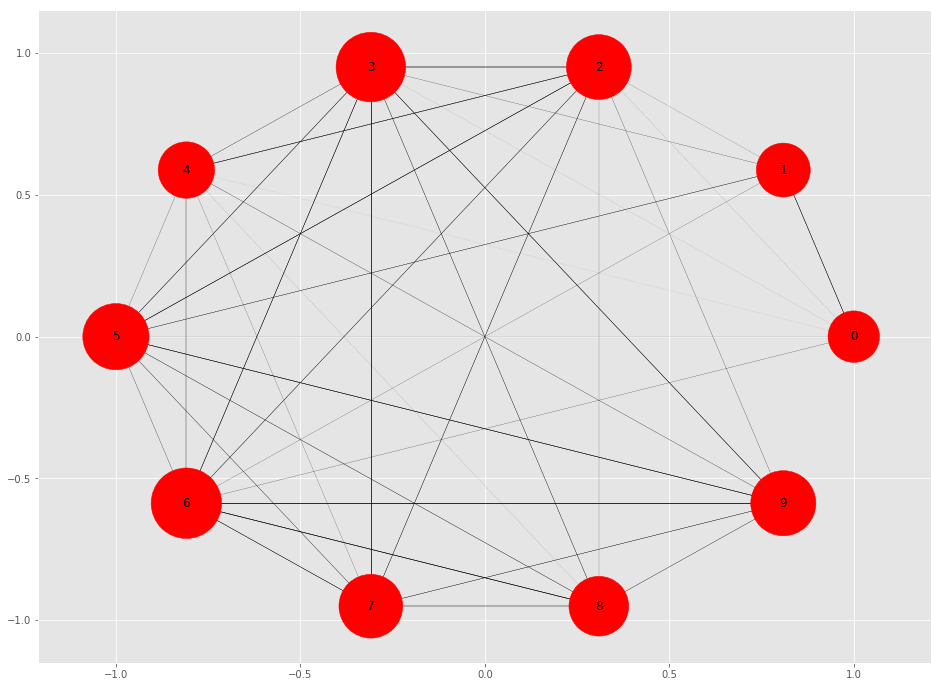

In [104]:
figure, ax = plt.subplots(figsize = (16,12))
netwrk = nx.draw_networkx(G, pos = nx.shell_layout(G), with_labels = True, edgelist = edges, width = w_arr, ax = ax,
                 node_size = n_sizes)
plt.savefig("graph_theory.png")

In [99]:
posts[3]

'hey guys i just feel like having a rant about life   im just fed up with trying to fight this anxiety hopes of recovery seem to come and then go when i find im not having progress ive got a new therapist and shes great i recommend private all the way but i know how to recover i just dont seem to    i try to think positively but i dont see the results and then go back to my negative thoughts cus they feel like what i should be feeling like im lying to myself if i think differently like ignoring them   now im not too bad socially with people i just seem to be bad with women i find attractive i want a partner but these thoughts stop me it really pisses me off i hate them but seem to feel oddly comforted by them the main thoughts i fall back on are women should find me attractive i must ugly if they dont want to date me   most areas of my life are good ive got a well paying job even though i hate it sometimes i have a very loving family even with arguments i have loads of freinds more tha

In [100]:
posts[7]

'hi   i need some advice im slowly learning to use cbt to overcome my anxiety i have to use self help for various reasons i have a really hard time with a few particular automatic thoughts that just dont go away and unfortunately they are directed towards recovery   i have thoughts like this is never going to work i will have anxiety forever im a loser see look i feel anxious two therapists gave up on me why will i do any better i cant control my thoughts   annoyingly cbt seems to cause me to have really persistent ants and because these thoughts act against the cbt they make it really hard its like a vicious cycle i can rationalise some ants when i do a mood journal but these ants then pop up ive tried rationalising them but it gets worse and then i go into full blown panic because everytime i rationalise them my brain just doesnt believe it and it starts shouting them at me has anyone got any solutions they pop up when i do mindfulness meditation too   could i have ocd without compul

In [102]:
posts[0]

'hey i phoned my local afco and they said i can still apply and that during the medical they might want to probe into it further the officer i spoke to said the medical requirements for wsop were the same as air traffic controller i know im clutching at straws but also i took the online spin test a medical test to see how high my sa is and i scored 23 indicating mild social anxiety  am i being too hopeful'

**split into auth and responder**

In [54]:
health = df[df['post'].str.contains("anxiety|anxious|social anxiety|panic|gad|GAD|fear|worry")]

In [55]:
len(health)

17694

In [13]:
auth = df[df['post_type'] == 'author']
res = df[df['post_type'] == 'responder']

**split responder df into 2dfs - 1) contain a personal regex string, 2) does not contain regex string**

**relabel personal responders as 0**

In [14]:
# res_per = res[res['post'].str.contains("(i feel|im feeling|im worried|my anxiety|i have felt)", regex = True)]
# res_no = res.drop(res_per.index)

# res_per['label'] = 0 

**merge author df and the responder df that contains personal posts** 

**relabel other df of responders that does not contain personal regex string** 

In [15]:
#know the type of post
df_know = pd.concat([auth, res_per])
df_know.reset_index(drop = True, inplace = True)

#responders do not contain regex string
df_res = res_no
df_res.reset_index(drop = True, inplace = True)

**Filter responder df so that it will only contain impersonal posts**

**create a new df of responders where i'm uncertain about the content of post called df_predict**

In [16]:
indices_to_remove = []
for i,p in enumerate(df_res['post']):
    len_doc = len(p.split())
    if len(p.split()) == 0:
        indices_to_remove.append(i)
        continue
        
    numi = p.split().count("i") + p.split().count("im")
    numyou = p.split().count("you")+ p.split().count("your") + p.split().count("youre") + p.split().count("u")
    i_rate = numi/len_doc
    you_rate = numyou/len_doc
    
    if df_res['label'][i] == 0:
        continue
    elif (i_rate > you_rate):
        indices_to_remove.append(i)
    elif (i_rate > you_rate):
        indices_to_remove.append(i)
    else:
        continue
        
df_predict = pd.concat([df_res.iloc[indices_to_remove]])
df_res.drop(df.index[[indices_to_remove]], inplace = True)
df_res.reset_index(drop= True, inplace = True)

**Filter out authors who don't have any 1st person pronouns and add to df_predict (uncertain)**

**Create df_know (have a good idea of content of post - personal or not)**

**df_know - used to train Naive Bayes**

**df_predict - used to predict other responses**


In [17]:
author_to_remove = []
for i,p in enumerate(df_know['post']):
    if p.split().count("i") + p.split().count("im") == 0:
        author_to_remove.append(i)
    else:
        continue

        
df_predict = pd.concat([df_predict, df_know.iloc[author_to_remove]])
df_know.drop(df_know.index[[author_to_remove]], inplace = True)

df_know = pd.concat([df_know, df_res])
df_know.reset_index(drop = True, inplace = True)

df_predict.reset_index(drop = True, inplace = True)

**Look at value counts of my labels in df_know**

In [18]:
df_know['label'].value_counts()

1    16292
0    11311
Name: label, dtype: int64

**create docs and find word counts for NB**

In [19]:
#create docs
docs = [df_know['post'][i] for i in range(0,len(df_know))]

#get tokens
tokens = set()
for doc in docs:
    tokens.update(doc.split())
    
tokens_list = list(tokens)

vocab_dict = {word: i for i, word in enumerate(tokens_list)}

import numpy as np

word_counts = np.zeros((len(docs), len(tokens)), dtype = 'float32')
for doc_id, words in enumerate(docs):
    for word in words.split():
        word_id = vocab_dict[word]
        word_counts[doc_id][word_id] += 1

## Train Naive Bayes Model

**create Naive Bayes instance**

In [20]:
clf = MultinomialNB()

**Train,Test split**

In [21]:
X = word_counts
y = np.array(df_know['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 38)

**Fit model**

In [22]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Test model accuracy (based on assumptions i already made)**

In [23]:
clf.score(X_test,y_test)

0.8940409346132947

## Predict with NB

- Predict on uncertain responders

**create docs**

In [24]:
docs = df_predict['post']

**get word counts**

In [25]:
import numpy as np

word_counts = np.zeros((len(docs), len(tokens)), dtype = 'float32')
for doc_id, words in enumerate(docs):
    for word in words.split():
        if word not in vocab_dict:
            continue
        else:
            word_id = vocab_dict[word]
            word_counts[doc_id][word_id] += 1

**soft classification**

In [26]:
X = word_counts

labels_proba = clf.predict_proba(X)

**hard classification**

In [27]:
labels = clf.predict(X)


**drop hold labels which are just 9 for uncertain**

In [28]:
df_predict.drop("label", axis = 1, inplace = True)

**Add predicted soft and hard labels**

In [29]:
df_predict['hard'] = labels
df_predict['soft'] = labels_proba[:,0]
df_predict.reset_index(drop = True, inplace = True)

**Check prediction**

In [30]:
pd.set_option('max_colwidth' , 200)
df_predict.head(10)

,pid,user,post_title,post,post_type,mood,thread_title,forum_name,postlen,hard,soft
0,1592736,Zardos,nan,i can sympathize i get crippling anxiety when i go to bed and first thing on a morning it gets better during the day when im busy and then at night i dont want to get into bed has anything chang...,responder,nan,Sudden Onset Anxiety - Please help!,Generalized Anxiety Disorder,62,0,1.000000
1,585119,Mayfair,nan,great tune i had my beatles number one hits in my car last week they are genius with chords thats their secret but only weirdos like me recognise it my car got broke into last week and they empti...,responder,nan,didnt know where to post this,Social Anxiety,89,0,0.998539
2,586791,Ainsworth11,nan,why did i post this in social anxiety ah well never mind i got some sleepers from boots yesterday slept for 4 hours but felt i had been hit round the head with a baseball bat when i woke up as y...,responder,nan,didnt know where to post this,Social Anxiety,62,0,0.999999
3,1599105,Macka,nan,hi ark i also love writing something in me since i can remember when i was in the beginnings of my breakdown i wrote 30000 words in ten days my pc permanently crashed and so did my brain when...,responder,Inspired,"Is this GAD? My mind keeps creating associations between things and anxiety, and they're ruining my life!",Generalized Anxiety Disorder,335,0,1.000000
4,586857,wendolene26,nan,the beatles help album was the first cd album i got given when my parents bought my a cd player hifi i was learning guitar and playing a lot of the beatles tunes as they have easy chords so i sup...,responder,Paranoid,didnt know where to post this,Social Anxiety,46,0,0.916680
5,1598695,blacksmoke,nan,hello janey1966 hey janey yeah the second half of life stinks i am really seeing my mother for who she really is fooled myself for the first half really sorry for what you are going through yeah ...,responder,Sad,Feeling More Anxious The Older I Get. I Am 51.,Generalized Anxiety Disorder,60,0,0.923886
6,1598189,frogsplash,nan,hi i would recommend watching some youtube videos regarding dealing with anxiety and worrying less,responder,nan,feeling anxious,Generalized Anxiety Disorder,15,1,0.284101
7,536359,yesican,nan,i wish it was just one beer one beer doesnt do anything for me it starts with a beer then two then three and so on i dont get drunk but i definitely do drink too much its not good for my health me...,responder,Blah,social anxiety... causing me to drink too much,Social Anxiety,97,0,1.000000
8,536365,yesican,nan,no i am sure that we havent spoken before this is my first time talking about this on a forum,responder,Blah,social anxiety... causing me to drink too much,Social Anxiety,20,0,0.901430
9,536367,yesican,nan,i am trying to figure out who i am i have no idea im confused i have a job interview tomorrow and im already freaked out because i know i will be staring at the man and probably make him feel unco...,responder,Blah,social anxiety... causing me to drink too much,Social Anxiety,60,0,1.000000


# Manually labeling nonsense

In [14]:
def manlab_n(df_pkl, rx,  col):
    pd.set_option('max_colwidth' , 200)
    df = pd.read_pickle(df_pkl)
    df_res = df[df['post_type']== "responder"]
    df_lab = df_res[df_res['post'].str.contains(rx , regex = True)]
    proceed = input("Proceed: ")
    n = 1
    while proceed  == 'y':
        if n%10 == 0:
            proceed = input("Proceed: ")
        ind = int(np.random.choice(df_lab.index, size = 1))
        label = (input("Personal(0) {} / {}: ".format(n, df['post'].iloc[ind])))
        if label == 'x':
            break
        label = int(label)
        df[col][ind] = label
        n += 1
    #safety saving
    df.to_pickle('df_man.pkl')
    return df

# Creating TFIDF pkl

In [31]:
# getting predicted personals from responders
df_predicted_p = df_predict[df_predict['hard'] == 0]

In [36]:
#combining all personals
df_personal = pd.concat([df_know, df_predicted_p])
df_personal.reset_index(drop = True, inplace = True)

In [37]:
len (df_personal)

39221

In [38]:
joblib.dump(df_personal, "df_personal.pkl")

['df_personal.pkl']

In [39]:
#creating user list for each post
users = [df_personal['user'][i] for i in df_personal.index]

In [40]:
# creating post list
posts = [df_personal['post'][i] for i in df_personal.index]

In [42]:
#vectorizing
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7, max_features = 10000)
vect = vectorizer.fit_transform(posts).astype('float32')

In [43]:
#joblib the model
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [44]:
# joblib the matrix
joblib.dump(vect, "vect.pkl")



['vect.pkl']